In [1]:
%run init_notebook.py
from settings import DATA_DIR, GRAPHS_DIR

In [2]:
from src.utils import *

In [3]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import spacy
import regex as re

import chromadb

from uuid import uuid4

from itertools import chain
from collections import Counter

from datetime import datetime

In [4]:
# load ecb speeches

In [5]:
f = open(os.path.join(DATA_DIR, 'ecb_speeches.pickle'), 'rb')
speeches = pickle.load(f)
f.close()

speeches = dict(zip([str(uuid4()) for i in range(0, len(speeches))], list(speeches.values())))


In [6]:
N = -1
documents = [v['text'] for k,v in speeches.items()]
docs_spacy = [v['doc'] for k,v in speeches.items()]
embeds = [list(v['doc'].vector) for k,v in speeches.items()]
metadatas = [{'date': str(v['date']), 'title': v['title'], 'url': v['url']} for k,v in speeches.items()]
ids = list(speeches.keys())
dict_dates = {k: v['date'] for k,v in speeches.items()}

In [7]:
# tf-idf

In [8]:
propns = {
    ids[idx]: 
    [
        t.lemma_ for t in docs_spacy[idx] if 
        (t.pos_ in ["PROPN", "NOUN"]) 
        and re.fullmatch(r"[^a-zA-Z0-9]", t.lemma_) is None
    ] 
    for idx in range(len(docs_spacy))
}

In [9]:
from collections import Counter

In [10]:
tf = {}
for idx, terms in propns.items():
    counter = Counter(terms)
    _freq = np.array(list(counter.values())) / sum(counter.values())
    tf[idx] = dict(zip(counter.keys(), _freq))
    
bag_of_words = list(set([*chain(*[list(i.keys()) for i in list(tf.values())])]))
lst_doc_words = [list(v.keys()) for k,v in tf.items()]
idf = {}
for term in bag_of_words:
    idf[term] = np.log(len(lst_doc_words) / (1 + sum([term in d for d in lst_doc_words]))) + 1

In [11]:
tf_idf = {idx: {k: idf[k] * v for k,v in doc.items()} for idx,doc in tf.items()}

In [12]:
df_tf = pd.DataFrame(tf).transpose()
df_tf['date'] = df_tf.index.map(dict_dates)
df_tf.sort_values('date', inplace=True)
df_tf.index.name = 'uuid'
# df_tf.drop('date', axis=1, inplace=True)

In [13]:
df_tfidf = pd.DataFrame(tf_idf).transpose()
df_tfidf['date'] = df_tfidf.index.map(dict_dates)
df_tfidf.sort_values('date', inplace=True)
df_tfidf.index.name = 'uuid'
# df_tfidf.drop('date', axis=1, inplace=True)

In [14]:
save_pd_df(df_tf, 'ecb_tf.csv')
save_pd_df(df_tfidf, 'ecb_tfidf.csv')

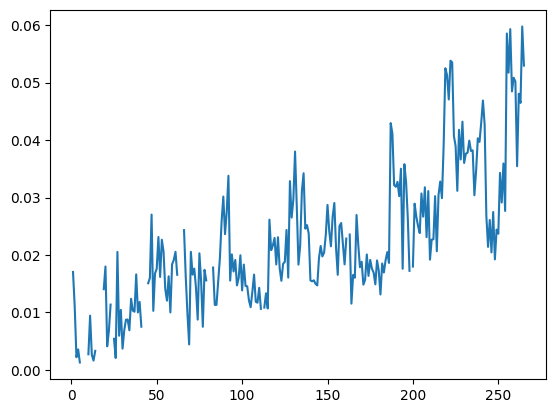

In [15]:
plt.plot(df_tf['inflation'].values)

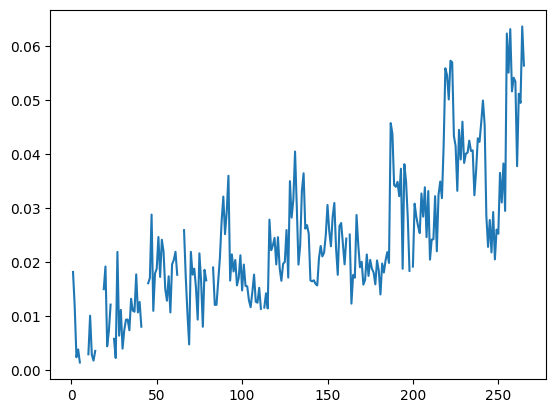

In [16]:
plt.plot(df_tfidf['inflation'].values)

In [17]:
# plot

In [18]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()

In [19]:
lst_terms_all = ['interest', 'inflation', 'energy', 'war', 'credit']
lst_terms_stability = ['stability', 'pressure', 'uncertainty', 'war', 'credit', 'risk']
sub = df_tfidf[lst_terms_all].copy()
sub.index = sub.index.map(dict_dates)
sub.index.name = 'date'

''

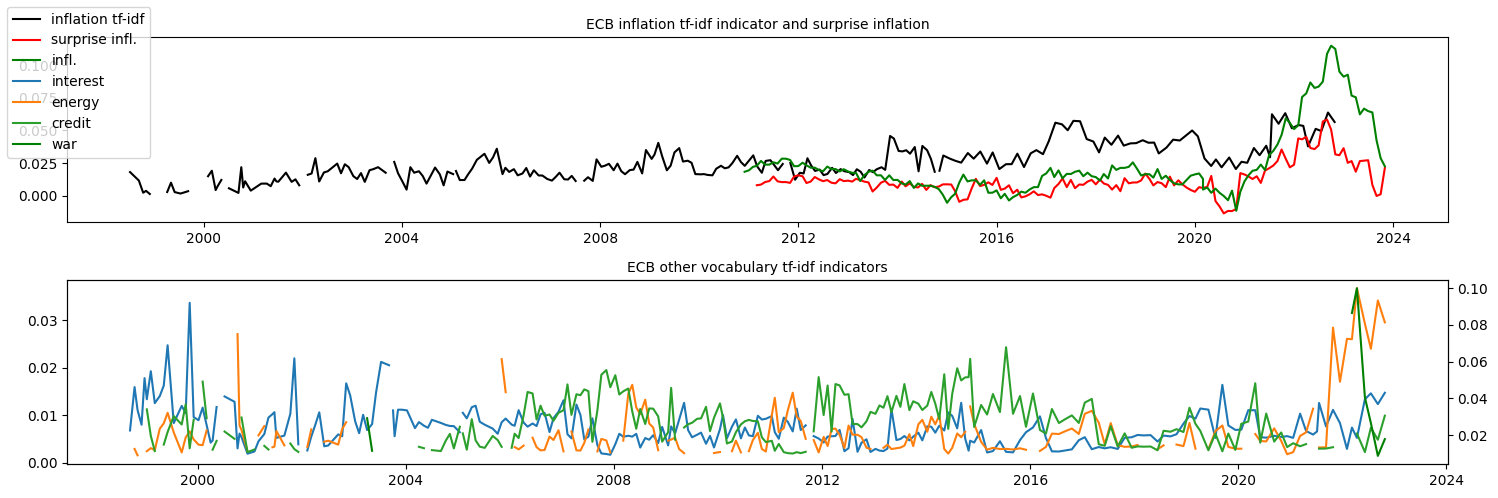

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15,5))
ax[0].plot(sub['inflation'], color='black', label='inflation tf-idf')
ax[0].plot(infl['pi_de_surprise_Y'], color='red', label='surprise infl.')
ax[0].plot(infl['pi_de_Y'], color='green', label='infl.')

ax[1].plot(sub.drop(['inflation', 'war'], axis=1), label=sub.drop(['inflation', 'war'], axis=1).columns)
ax[1].twinx().plot(sub['war'], label='war', color='green')

fig.legend(loc='upper left')

ax[0].set_title("ECB inflation tf-idf indicator and surprise inflation", size=10)
ax[1].set_title("ECB other vocabulary tf-idf indicators", size=10)

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph4.png'), )
;


In [21]:
# LDA

In [27]:
txts = [
    [*chain(*[
        [i.lemma_.lower() for i in [*sent] if (not (i.is_stop or i.is_punct) and i.pos_ in ["NOUN", "PROPN"])]
        for sent in doc.sents
    ])]
    for doc in docs_spacy
]

In [23]:
from collections import Counter

In [24]:
Counter([*chain(*txts)])['inflation']

2579

In [30]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(txts)
corpus = [id2word.doc2bow(text) for text in txts]

In [38]:
import gensim
import pprint

In [39]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=101)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.029*"euro" + 0.027*"inflation" + 0.026*"area" + 0.024*"growth" + 0.022*"price" + 0.019*"rate" + 0.017*"policy" + 0.015*"term" + 0.012*"governing" + 0.011*"market"'), (1, '0.032*"price" + 0.029*"area" + 0.029*"euro" + 0.028*"growth" + 0.025*"rate" + 0.021*"term" + 0.019*"inflation" + 0.016*"council" + 0.015*"policy" + 0.013*"development"'), (2, '0.031*"growth" + 0.028*"euro" + 0.024*"area" + 0.022*"rate" + 0.021*"inflation" + 0.020*"price" + 0.019*"term" + 0.018*"policy" + 0.014*"development" + 0.011*"governing"')]


In [102]:
import pyLDAvis.gensim
# import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
# # LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
        # pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
# # with open(LDAvis_data_filepath, 'rb') as f:
#     # LDAvis_prepared = pickle.load(f)
# # pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared


TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [43]:
c = [id2word.doc2bow(txts[i]) for i in range(10, 13)]
c = id2word.doc2bow(txts[10])
topics = {i: dict(lda_model.get_document_topics(id2word.doc2bow(txts[i]))) for i in range(len(txts))}

In [66]:
df = pd.DataFrame(topics) #columns=dict_dates.values())
df.columns = list(dict_dates.values())
df = df.T.sort_index()
df.columns = [f'topic_{i}' for i in df.columns]

In [100]:
lda_model.print_topic(2)

'0.031*"growth" + 0.028*"euro" + 0.024*"area" + 0.022*"rate" + 0.021*"inflation" + 0.020*"price" + 0.019*"term" + 0.018*"policy" + 0.014*"development" + 0.011*"governing"'

<AxesSubplot: >

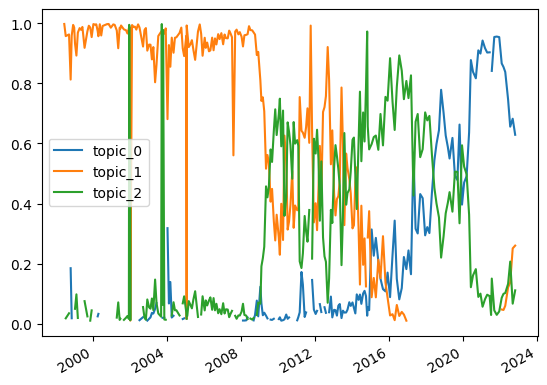

In [68]:
df.plot()

In [69]:
# test for significance

In [196]:
data = df_tf[['inflation']].copy()
data.index = data.index.map(dict_dates)
# data = data.join(df[['topic_0']])

In [197]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv'))

In [198]:
data.index.name = 'date'

In [199]:
data['M'] = data.index.to_period('M').to_timestamp()

In [200]:
data = data.set_index('M').join(infl[['pi_de_Y']])
data = data.apply(lambda x: (x - x.mean())/(x.std()))

In [202]:
from scipy.stats import multivariate_normal

In [203]:
mu, cov = data.mean().values, data.dropna().cov().values
mvn = multivariate_normal(mean=mu, cov=cov)

In [213]:
mvn.pdf(np.array([.1, .3]), 

0.17450471952071947

''

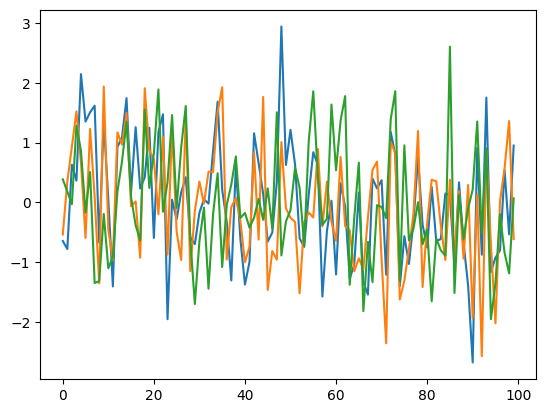

In [156]:
plt.plot(mvn.rvs(100))
;

<AxesSubplot: xlabel='M'>

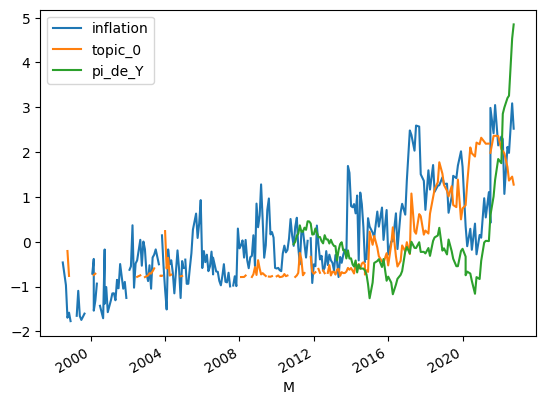

In [157]:
data.plot()

In [158]:
# VAR

In [159]:
from statsmodels.tsa.vector_ar.var_model import VAR

<AxesSubplot: xlabel='M'>

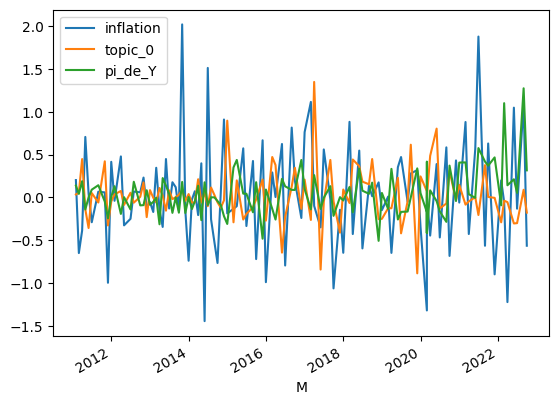

In [176]:
data.dropna().diff().plot()

In [177]:
var = VAR(data.dropna().diff().dropna()).fit(maxlags=15, ic='aic')
var.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Feb, 2024
Time:                     12:07:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.78006
Nobs:                     107.000    HQIC:                  -5.95830
Log likelihood:          -118.209    FPE:                 0.00228884
AIC:                     -6.07982    Det(Omega_mle):      0.00205021
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.028051         0.056927            0.493           0.622
L1.inflation        -0.348003         0.093309           -3.730           0.000
L1.topic_0          -0.051831         0.186154           -0.

In [181]:
var.test_causality('pi_de_Y', 'topic_0').summary()

Test statistic,Critical value,p-value,df
1.122,3.872,0.290,"(1, 309)"


In [182]:
# bayes theorem

$$ p(\pi|x) = \frac{p(i) f(i|\pi)}{f(i)} $$